In [18]:
!pip install tensorflow numpy matplotlib opencv-python scikit-learn

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
import cv2
import os

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = "brain_tumor_dataset/no"
train_dir = "brain_tumor_dataset/train/no"
val_dir = "brain_tumor_dataset/val/no"

# Create directories if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get all image filenames
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

for img in train_images:
    shutil.move(os.path.join(source_dir, img), os.path.join(train_dir, img))

for img in val_images:
    shutil.move(os.path.join(source_dir, img), os.path.join(val_dir, img))

print("Dataset split complete.")


Dataset split complete.


In [25]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    "brain_tumor_dataset/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)

val_generator = data_gen.flow_from_directory(
    "brain_tumor_dataset/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode='input'
)


Found 73 images belonging to 1 classes.


Found 19 images belonging to 1 classes.


In [26]:
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [27]:
autoencoder = build_autoencoder()

autoencoder.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=50
)

d:\Data Science\Deep Learning\Projects\Anomaly Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - loss: 0.1371 - val_loss: 0.1264
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - loss: 0.1201 - val_loss: 0.1039
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.1125 - val_loss: 0.0929
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.1059 - val_loss: 0.0812
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - loss: 0.0907 - val_loss: 0.0574
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0627 - val_loss: 0.0358
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0453 - val_loss: 0.0264
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0323 - val_loss: 0.0249
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0302 - val_loss: 0.0243
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0267 - val_loss: 0.0220
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.0252 - val_loss: 0.0202
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 0.0251 - val_lo

In [28]:
def detect_anomalies(model, test_images):
    anomalies = []
    for img in test_images:
        original = cv2.resize(img, (128, 128))
        original = original.astype('float32') / 255.0
        reconstructed = model.predict(np.expand_dims(original, axis=0))[0]
        
        mse = mean_squared_error(original.flatten(), reconstructed.flatten())
        if mse > 0.01:  # Adjust threshold accordingly
            anomalies.append((original, reconstructed, mse))
    return anomalies


In [29]:
def visualize_results(anomalies):
    for original, reconstructed, mse in anomalies[:5]:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(original)
        axs[0].set_title("Original Image")
        axs[1].imshow(reconstructed)
        axs[1].set_title(f"Reconstructed (MSE: {mse:.4f})")
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

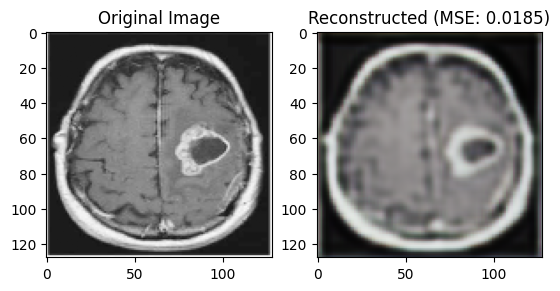

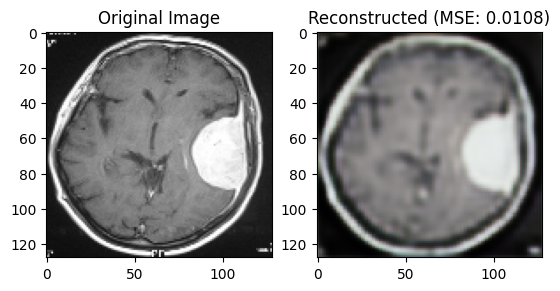

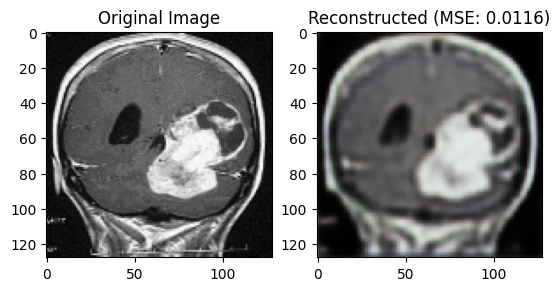

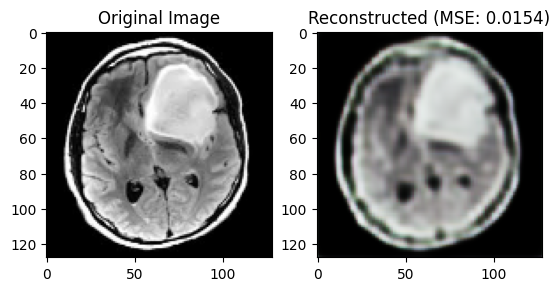

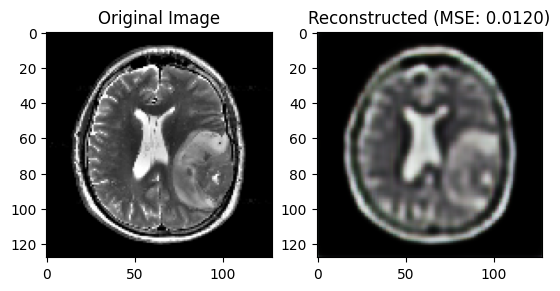

In [30]:
test_images = [cv2.imread(os.path.join("brain_tumor_dataset\yes", img)) for img in os.listdir("brain_tumor_dataset\yes")]

anomalies_detected = detect_anomalies(autoencoder, test_images)
visualize_results(anomalies_detected)


In [31]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.save("autoencoder_model.h5")
